## Librerías y funciones

Lo primero es cargar las librerías y funciones genéricas necesarias.

In [1]:
import pandas as pd
import numpy as npte
import re
import seaborn as sns
import unicodedata
import string
from stop_words import get_stop_words
from collections import Counter
import nltk
nltk.download('wordnet')

seed = 17

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas
import random

#import spacy

#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk import ngrams
from nltk.probability import FreqDist

from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_recall_curve,make_scorer, recall_score, accuracy_score, precision_score

import gzip
import pickle
#!pip install textstat
from textstat.textstat import *

[nltk_data] Downloading package wordnet to /Users/aaron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# función para el cálculo de palabras, bigramas y trigramas
def get_vocabulary(df, col_name):
    
    words_ = []
    bigrams_ = []
    trigrams_ = []
    
    # iteramos para cada tweet y cada palabra
    for tweet in df[col_name]:
        for word in tweet.split():
            words_.append(word)
    
    # generamos bigramas y trigramas
    bigrams_ = list(ngrams(words_, 2))
    trigrams_ = list(ngrams(words_, 3))
    
    # diccionario con las tres categorías
    vocab = {
        'words': words_,
        'bigrams': bigrams_,
        'trigrams': trigrams_
    }
    
    return vocab

## 1. Carga de datos


In [3]:
df = pd.read_csv('./data/labeled_data.csv')

In [4]:
full_df = pd.read_csv('./labeled_data.csv', index_col = 0)

# separamos entre project (95% de full_df) y test (5% de full_df)
project, test = train_test_split(full_df, 
                                 test_size = 0.05, 
                                 shuffle = True, 
                                 random_state = 0, 
                                 stratify = full_df['class'])

project = project.reset_index()#.drop('index', axis = 1)
test = test.reset_index()#.drop('index', axis = 1)

# separamos entre train (80% de project) y validación (20% de project)
train, val = train_test_split(project, 
                              test_size = 0.2, 
                              shuffle = True, 
                              random_state = 0, 
                              stratify = project['class'])

train = train.reset_index()#.drop('index',axis = 1)
val = val.reset_index()#.drop('index',axis = 1)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')
print(f'Dimensiones del dataset de validation: {val.shape}')

# Guardamos
train.to_csv('./train.csv', sep = ';', decimal = '.', index = False)
val.to_csv('./val.csv', sep = ';', decimal = '.', index = False)
test.to_csv('./test.csv', sep = ';', decimal = '.', index = False)

Dimensiones del dataset de training: (18834, 8)
Dimensiones del dataset de test: (1240, 7)
Dimensiones del dataset de validation: (4709, 8)


In [5]:
full_df.head()

count  hate_speech  offensive_language  neither  class  \
Unnamed: 0                                                           
0               3            0                   0        3      2   
1               3            0                   3        0      1   
2               3            0                   3        0      1   
3               3            0                   2        1      1   
4               6            0                   6        0      1   

                                                        tweet  
Unnamed: 0                                                     
0           !!! RT @mayasolovely: As a woman you shouldn't...  
1           !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2           !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3           !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4           !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [6]:
df = train.copy()
df.head(5)

index  Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0   4253       14594      3            0                   3        0      1   
1   3996       16954      3            0                   0        3      2   
2  22484        5200      3            0                   0        3      2   
3   5987        3907      3            1                   0        2      2   
4   6725       18721      6            0                   6        0      1   

                                               tweet  
0  RT @CapitalT____: How you put ya hoes before y...  
1  RT @PriyaOhol: In Hopes of Recruiting More Wom...  
2  @Yankees @marines1994 Daggone it Twins, kick i...  
3  @LeonCountryBwoy your a big yute to be having ...  
4  RT @carterreynolds: Austin Mahone is making bi...

In [7]:
# cálculo de caraterísticas
df['hate_speech'] = df['hate_speech'] / df['count'] 
df['offensive_language'] = df['offensive_language'] / df['count'] 
df['neither'] = df['neither'] / df['count'] 

###  Verificamos la estructura del DF

In [8]:
print('Dimensiones del DataFrame son {}'.format(df.shape))

Dimensiones del DataFrame son (18834, 8)


### Trabajamos únicamente con los tweets como campo de texto

In [9]:
df = df[['tweet','class']]
df.head(5)

tweet  class
0  RT @CapitalT____: How you put ya hoes before y...      1
1  RT @PriyaOhol: In Hopes of Recruiting More Wom...      2
2  @Yankees @marines1994 Daggone it Twins, kick i...      2
3  @LeonCountryBwoy your a big yute to be having ...      2
4  RT @carterreynolds: Austin Mahone is making bi...      1

In [10]:
# Filtramos los datos
df_hate = df[df['class'] == 0]
df_offensive = df[df['class'] == 1]
df_neither = df[df['class'] == 2]

## 2. Pre-procesamos el texto

Con el objetivo de normalizar el texto de los tweets, así como de trabajar con un vocabulario menor que el original que contenga menos palabras que aporten poca información, la etapa de procesado de texto propuesta consiste en:

- Conversión de todo el texto a minúsculas
- Eliminación de números (dígitos)
- Eliminación de símbolos
- Eliminación de signos de puntuación
- Lemmatización sin desambiguación (búsqueda directa en diccionario de formas flexionadas y lemmas)

#### Stopwords

In [11]:
sw = get_stop_words('english').extend(['mentionhere', 'urlhere'])
#sw = sw.extend(['the','you','as','is','of','that','my','and','to','in','me','it','are','all','for','this','be','your','so','these'])

#### Funciones de preprocesado

In [12]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

def text_normalizer(text, sw_list = sw):  
    if sw_list is None:
        sw_list = []
    # Convierte el texto a minúsuculas
    text = text.lower()    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')    
    # Elimina caracteres no alfabéticos
    text = re.sub("[^A-Za-z']+", ' ', str(text)) 
    # Elimina caracteres "rt" de retweet
    text = re.sub('rt[\s]+', '', text)    
    # Elimina hipervínculos
    #text = re.sub('https?:\/\/.*[\r\n]*', '', text)    
    # Elimina hashtag
    text = re.sub('#', '', text)    
    # Eliminar stop_words
    text = ' '.join([word for word in text.split() if word not in (sw_list)])    
    # Init the Wordnet Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize list of words and join
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])   
    return text
    
def remove_slang(text):
    # Remove slang words
    d = {'luv':'love', 'wud':'would', 'lyk':'like', 'wateva':'whatever',
         'ttyl':'talk to you later', 'kul':'cool', 'fyn':'fine', 'omg':'oh my god!', 
         'fam':'family', 'bruh':'brother', 'cud':'could', 'nicca':'nigger', 
         'nigga':'nigger', 'nig':'nigger', 'nigguh':'nigger', 'niggah':'nigger', 
         'fuckin':'fucking'}
    text = text.split()
    reformed = [d[word] if word in d else word for word in text]
    text = ' '.join(reformed)
    return text

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    ##SENTIMENT
    #sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = text_normalizer(preprocess(tweet), sw) #Get text only
    
    syllables = textstat.syllable_count(words) # count syllables in words
    num_chars = sum(len(w) for w in words) # num chars in words
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    features = [syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms,] 
    return features

In [13]:
# preprocesado y normalización de tweets
df['prepro_tweet'] = df['tweet'].apply(lambda txt: preprocess(txt))
df['norm_tweet'] = df['prepro_tweet'].apply(lambda txt: text_normalizer(txt))

In [14]:
# guardamos datos preprocesados para un estudio comparativo posterior
df.to_csv('data/labeled_data_preprocessed.csv')

In [15]:
# enriquecimiento del df
other_features_cols = ['syllables', 'avg_syl', 'num_chars', 'num_chars_total', 
                       'num_terms', 'num_words', 'num_unique_terms']

i = 0
for col in other_features_cols:
    df[col] = df['tweet'].apply(lambda txt: other_features(txt)[i])
    i += 1

In [16]:
df.head()

tweet  class  \
0  RT @CapitalT____: How you put ya hoes before y...      1   
1  RT @PriyaOhol: In Hopes of Recruiting More Wom...      2   
2  @Yankees @marines1994 Daggone it Twins, kick i...      2   
3  @LeonCountryBwoy your a big yute to be having ...      2   
4  RT @carterreynolds: Austin Mahone is making bi...      1   

                                        prepro_tweet  \
0  RT : How you put ya hoes before ya girlfriend ...   
1  RT : In Hopes of Recruiting More Women, ISIS O...   
2    Daggone it Twins, kick it up a notch... Time...   
3   your a big yute to be having slits in your br...   
4  RT : Austin Mahone is making bitches horny rig...   

                                          norm_tweet  syllables  avg_syl  \
0            how you put ya hoe before ya girlfriend         10   1.2500   
1  in hope of recruiting more woman isi open jiha...         18   1.6363   
2  daggone it twin kick it up a notch time to bea...         15   1.1538   
3  your a big yute to be having slit in your brow...         18   1.0588   
4      austin mahone is making bitch horny right now         10   1.2500   

   num_chars  num_chars_total  num_terms  num_words  num_unique_terms  
0         39               71         12          8                 7  
1         65              146         17         11                11  
2         58               89         15         13                12  
3         70               89         18         17                16  
4         45               70         10          8                 8

In [17]:
analyser = SentimentIntensityAnalyzer()

In [18]:
# function to calculate polarity scores
pol = lambda x: analyser.polarity_scores(x)

In [19]:
df_vader = df[['norm_tweet','class']]

In [20]:
# creating new column 'polarity'
df_vader['polarity'] = df_vader['norm_tweet'].apply(pol)

In [21]:
df_vader.head()

norm_tweet  class  \
0            how you put ya hoe before ya girlfriend      1   
1  in hope of recruiting more woman isi open jiha...      2   
2  daggone it twin kick it up a notch time to bea...      2   
3  your a big yute to be having slit in your brow...      2   
4      austin mahone is making bitch horny right now      1   

                                            polarity  
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1  {'neg': 0.0, 'neu': 0.775, 'pos': 0.225, 'comp...  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3  {'neg': 0.106, 'neu': 0.754, 'pos': 0.141, 'co...  
4  {'neg': 0.352, 'neu': 0.648, 'pos': 0.0, 'comp...

In [22]:
df_vader2 = pd.concat([df_vader.drop('polarity', axis = 1), 
                       df_vader['polarity'].apply(pd.Series)], axis = 1)
df_vader2.head()

norm_tweet  class    neg    neu  \
0            how you put ya hoe before ya girlfriend      1  0.000  1.000   
1  in hope of recruiting more woman isi open jiha...      2  0.000  0.775   
2  daggone it twin kick it up a notch time to bea...      2  0.000  1.000   
3  your a big yute to be having slit in your brow...      2  0.106  0.754   
4      austin mahone is making bitch horny right now      1  0.352  0.648   

     pos  compound  
0  0.000    0.0000  
1  0.225    0.4404  
2  0.000    0.0000  
3  0.141    0.1779  
4  0.000   -0.5859

In [23]:
# new dataframe with average polarity score for each label
scores_df = df_vader2.groupby('class')['pos'].mean().reset_index(name = 'avg_positive')
scores_df['avg_neutral'] = df_vader2.groupby('class')['neu'].mean()
scores_df['avg_negative'] = df_vader2.groupby('class')['neg'].mean()
scores_df['avg_compound'] = df_vader2.groupby('class')['compound'].mean()

In [24]:
scores_df.head()

class  avg_positive  avg_neutral  avg_negative  avg_compound
0      0      0.088969     0.608676      0.302347     -0.365892
1      1      0.102631     0.631554      0.265746     -0.304629
2      2      0.122829     0.803990      0.072870      0.086907

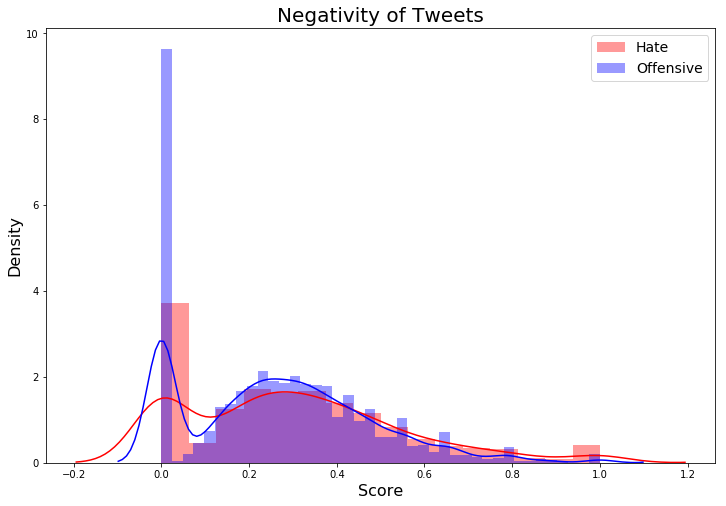

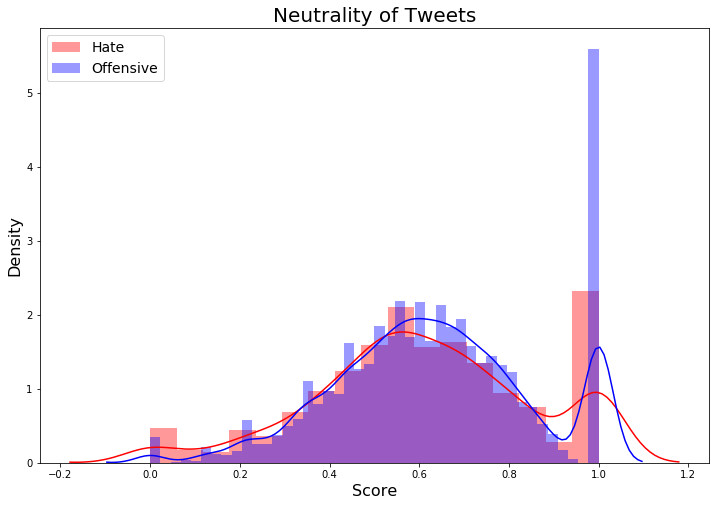

In [25]:
# Negativity plot
plt.figure(figsize = (12, 8))
ax = sns.distplot(df_vader2['neg'][df_vader2['class'] == 0], label = 'Hate', color = 'red')
ax = sns.distplot(df_vader2['neg'][df_vader2['class'] == 1], label = 'Offensive', color = 'blue')

# setting label, title and legend
ax.set_title('Negativity of Tweets', fontsize = 20) 
ax.set_ylabel('Density', fontsize = 16)
ax.set_xlabel('Score', fontsize = 16)
ax.legend(prop = dict(size = 14))

# Neutrality plot
plt.figure(figsize = (12, 8))
ax = sns.distplot(df_vader2['neu'][df_vader2['class'] == 0], label = 'Hate', color = 'red')
ax = sns.distplot(df_vader2['neu'][df_vader2['class'] == 1], label = 'Offensive', color = 'blue')

# setting label, title and legend
ax.set_title('Neutrality of Tweets', fontsize = 20) 
ax.set_ylabel('Density', fontsize = 16)
ax.set_xlabel('Score', fontsize = 16)
ax.legend(prop = dict(size = 14))


In [26]:
# Convertimos los tweets procesados en una matriz TF-IDF
cv1 = TfidfVectorizer(
    max_df = 0.95, # Se ignoran los términos que aparecen en más del 99% de los documentos
    min_df = 5,  # Se dejan fuera los términos que aparecen en 5 o menos documentos
    ngram_range = (1, 3) # Se consideran palabras, bigramas y trigramas
)
cv1.fit(df['norm_tweet'])

TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 3))

In [27]:
print(list(cv1.vocabulary_.items())[:10])

[('how', 3758), ('you', 9568), ('put', 6460), ('ya', 9490), ('hoe', 3591), ('before', 839), ('girlfriend', 3050), ('how you', 3785), ('you put', 9734), ('ya hoe', 9494)]


In [28]:
print(list(cv1.stop_words_)[0:10])

['stareading my own', 'fine ll', 'bitch whore', 'only white people', 'shit just blow', 'color don love', 'ima call his', 'love monkey', 'something enough you', 'you gunna do']


In [29]:
def vectorize(data, tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [30]:
# convertimos a df
x_train = df['norm_tweet'].to_frame()
x_train.shape

(18834, 1)

In [31]:
tfidf_vect_fit = cv1.fit(x_train['norm_tweet'])
X_train = vectorize(x_train['norm_tweet'], tfidf_vect_fit)

In [32]:
# comprobamos
X_train.shape

(18834, 9881)

In [33]:
# fusionamos data frames
x_train = pd.merge(X_train, df[['syllables', 'avg_syl', 'num_chars', 'num_chars_total', 'num_terms', 'num_words',
                'num_unique_terms', 'class']], left_index = True, right_index = True)
x_train.head()

ab  able  able to  abo  abortion  about  about being  about bitch  \
0  0.0   0.0      0.0  0.0       0.0    0.0          0.0          0.0   
1  0.0   0.0      0.0  0.0       0.0    0.0          0.0          0.0   
2  0.0   0.0      0.0  0.0       0.0    0.0          0.0          0.0   
3  0.0   0.0      0.0  0.0       0.0    0.0          0.0          0.0   
4  0.0   0.0      0.0  0.0       0.0    0.0          0.0          0.0   

   about everything  about fucking  about her  about hoe  about how  about it  \
0               0.0            0.0        0.0        0.0        0.0       0.0   
1               0.0            0.0        0.0        0.0        0.0       0.0   
2               0.0            0.0        0.0        0.0        0.0       0.0   
3               0.0            0.0        0.0        0.0        0.0       0.0   
4               0.0            0.0        0.0        0.0        0.0       0.0   

   about it like  about me  about my  about not  about obama  about other  \
0            0.0       0.0       0.0        0.0          0.0          0.0   
1            0.0       0.0       0.0        0.0          0.0          0.0   
2            0.0       0.0       0.0        0.0          0.0          0.0   
3            0.0       0.0       0.0        0.0          0.0          0.0   
4            0.0       0.0       0.0        0.0          0.0          0.0   

   about pussy  about that  about the  about their  about these  about this  \
0          0.0         0.0        0.0          0.0          0.0         0.0   
1          0.0         0.0        0.0          0.0          0.0         0.0   
2          0.0         0.0        0.0          0.0          0.0         0.0   
3          0.0         0.0        0.0          0.0          0.0         0.0   
4          0.0         0.0        0.0          0.0          0.0         0.0   

   about to  about to be  about to get  about week  about what  about you  \
0       0.0          0.0           0.0         0.0         0.0        0.0   
1       0.0          0.0           0.0         0.0         0.0        0.0   
2       0.0          0.0           0.0         0.0         0.0        0.0   
3       0.0          0.0           0.0         0.0         0.0        0.0   
4       0.0          0.0           0.0         0.0         0.0        0.0   

   about your  above  absolute  absolutely  abt  accent  accept  accept the  \
0         0.0    0.0       0.0         0.0  0.0     0.0     0.0         0.0   
1         0.0    0.0       0.0         0.0  0.0     0.0     0.0         0.0   
2         0.0    0.0       0.0         0.0  0.0     0.0     0.0         0.0   
3         0.0    0.0       0.0         0.0  0.0     0.0     0.0         0.0   
4         0.0    0.0       0.0         0.0  0.0     0.0     0.0         0.0   

   accident  accidentally  account  across  across the  act  act like  \
0       0.0           0.0      0.0     0.0         0.0  0.0       0.0   
1       0.0           0.0      0.0     0.0         0.0  0.0       0.0   
2       0.0           0.0      0.0     0.0         0.0  0.0       0.0   
3       0.0           0.0      0.0     0.0         0.0  0.0       0.0   
4       0.0           0.0      0.0     0.0         0.0  0.0       0.0   

   act like bitch  act like they  actin  actin like  acting  acting like  \
0             0.0            0.0    0.0         0.0     0.0          0.0   
1             0.0            0.0    0.0         0.0     0.0          0.0   
2             0.0            0.0    0.0         0.0     0.0          0.0   
3             0.0            0.0    0.0         0.0     0.0          0.0   
4             0.0            0.0    0.0         0.0     0.0          0.0   

   acting like bitch  acting like they  action  active  activity  actual  \
0                0.0               0.0     0.0     0.0       0.0     0.0   
1                0.0               0.0     0.0     0.0       0.0     0.0   
2                0.0               0.0     0.0     0.0       0.0     0.0   
3 

In [34]:
# renombramos columnas
x_train = x_train.rename(columns = {'neither_y': 'neither_language', 'neither_x':'neither', 
                                    'class_y': 'class_tweet', 'class_x':'class'})

In [35]:
# guardamos en formato pkl
x_train.to_pickle('train_proc.pkl.gz', compression = 'gzip')

#### Preprocesado al conjunto de validación

Para evitar la fuga de datos o "data leackage", haremos el procesado del conjunto de validación tal y como hemos hecho para el conjunto de entrenamiento. De esta forma, podemos validar nuestro modelo de una forma realista, ya que realizaremos el mismo procesado que para los datos de entrenamiento sin haber estudiado los datos de validación.

In [36]:
def procesado_val(df):
    # filtramos columnas
    df = df[['tweet','class']]
    
    # preprocesado y normalización de tweets
    df['prepro_tweet'] = df['tweet'].apply(lambda txt: preprocess(txt))
    df['norm_tweet'] = df['prepro_tweet'].apply(lambda txt: text_normalizer(txt))

    # enriguecemos del df
    i=0
    for col in other_features_cols:
        df[col] = df['tweet'].apply(lambda txt: other_features(txt)[i])
        i+=1
        
    # vectorizamos
    X_val = vectorize(df['norm_tweet'], tfidf_vect_fit)

    # fusionamos data frames
    x_val = pd.merge(X_val, df[['syllables', 'avg_syl', 'num_chars', 'num_chars_total', 'num_terms', 'num_words',
                'num_unique_terms', 'class']], left_index = True, right_index = True)
    
    # renombramos columnas
    x_val = x_val.rename(columns = {'neither_y': 'neither_language', 'neither_x':'neither', 
                                    'class_y': 'class_tweet', 'class_x':'class'})
    
    return x_val

In [37]:
# procesamiento de df_val
df_val = val.copy()
x_val = procesado_val(df_val)

# dimensiones
x_val.shape

(4709, 9889)

In [38]:
# guardamos en formato pkl
x_val.to_pickle('val_proc.pkl.gz', compression = 'gzip')

In [39]:
# proedimiento de carga de datos guardados
with gzip.open('train_proc.pkl.gz', 'rb') as f:
    train_set = pickle.load(f)
    
with gzip.open('val_proc.pkl.gz', 'rb') as f:
    val_set = pickle.load(f)